## 1. Data Munging

### Preliminary setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib
import json
import pandas as pd

from collections import OrderedDict

In [2]:
# Pandas config
pd.options.display.max_rows = 1600
pd.options.display.max_columns = 50

# Pyplot config
plt.rcParams.update({'font.size': 14})

In [3]:
# NHL season data
start_year = 2012 # 1917 is the first year with data
end_year = 2022
all_years = range(start_year, end_year, 1)
seasons = ['{}{}'.format(year, year+1) for year in all_years]
    
# Cup winners
#cup_winners = pd.read_csv('cup-winners.csv', names=['year', 'team', 'abbr'])
#cup_winners.loc[3] = ['2020', 'To Be Determined', 'TBD']
#cup_winners.index = seasons

In [ ]:
# NHL Team Index

teams_long = ['Anaheim Ducks',
              'Arizona Coyotes',
              'Boston Bruins',
              'Buffalo Sabres',
              'Calgary Flames',
              'Carolina Hurricanes',
              'Colorado Avalanche',
              'Columbus Blue Jackets',
              'Detroit Red Wings',
              'Edmonton Oilers',
              'Florida Panthers',
              'Montreal Canadiens',
              'New York Islanders',
              'New York Rangers',
              'Philadelphia Flyers',
              'Pittsburgh Penguins',
              'Seattle Kraken',
              'Toronto Maple Leafs',
              'Vancouver Canucks',
              'Vegas Golden Knights',
              'Winnipeg Jets']

### Clean build for current season

In [4]:
### THIS IS A CLEAN BUILD FOR THE CURRENT SEASON, JUST A TEMPLATE ###

# First get the team data into a dataframe
teams_req = urllib.request.urlopen('https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats')
teams_json = teams_req.read().decode()
teams_meta = dict(json.loads(teams_json))
teams_dict = {key['abbreviation']:key for key in teams_meta['teams']}
teams_df = pd.DataFrame.from_dict(teams_dict)

stats_dict = {team:teams_df[team]['teamStats'][0]['splits'][0]['stat'] for team in teams_df.columns}
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index')

# Next we can get player rosters
players_req = urllib.request.urlopen('https://statsapi.web.nhl.com/api/v1/teams?expand=team.roster')
players_json = players_req.read().decode()
players_meta = dict(json.loads(players_json))

### Pulling and building for all seasons

#### Team data

In [4]:
# Pull team data for all seasons from NHL API
teams_reqs = [urllib.request.urlopen( \
              'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season={}'.format( \
              season)) for season in seasons]

In [5]:
# Decode into readable JSON-like format
teams_jsons = [req.read().decode() for req in teams_reqs]

In [6]:
# Load in as JSON and collect appropriate segments into dictionary
teams_metas = [dict(json.loads(fread))['teams'] for fread in teams_jsons]

In [7]:
# Create list of all team data for each season
teams_dicts = [{key['abbreviation']:key for key in season} for season in teams_metas]

In [8]:
# Create master dictionary for all teams for each season
season_dict = dict(zip(seasons, teams_dicts))

In [9]:
# Create stats dictionary
stats_dict = {}

for key in season_dict:
    # Some seasons have no stats available, NaN results in KeyError
    try:
        stats_dict[key] = {season_dict[key][team]['abbreviation'] : \
                       season_dict[key][team]['teamStats'][0]['splits'][0]['stat'] \
                       for team in season_dict[key]}
    except KeyError:
    # Populate teams one at a time in years where some teams have no stats
        stats_dict[key] = {}
        for team in season_dict[key]:
            try:
                stats_dict[key][team] = season_dict[key][team]['teamStats'][0]['splits'][0]['stat']
            except KeyError:
                # Empty dictionary for teams with no stats (rather than NaN)
                stats_dict[key][team] = {key:0 for key in season_dict['20002001']['COL']['teamStats'][0]['splits'][0]['stat']}

In [10]:
# Create master dictionary of seasonal stats dataframes for each season
stats_dfs = {key:pd.DataFrame.from_dict(stats_dict[key], orient='index') for key in stats_dict}

In [11]:
# Append a new boolean array column to each seasonal dataframe to indicate Stanley Cup winner
#for key in stats_dfs:
#    win_bool = stats_dfs[key].index == cup_winners.loc[key]['abbr']
#    stats_dfs[key]['cupWin'] = win_bool

#### Player data (via ID lookup)

In [13]:
# Pull the roster data? 
player_reqs = [urllib.request.urlopen( \
              'https://statsapi.web.nhl.com/api/v1/teams?expand=team.roster&season={}'.format( \
              season)) for season in seasons]

In [14]:
# Decode into readable JSON-like format
player_jsons = [req.read().decode() for req in player_reqs]

In [15]:
# Load in as JSON and collect appropriate segments into dictionary
player_metas = [dict(json.loads(fread))['teams'] for fread in player_jsons]

In [16]:
# Create a dictionary that connects each season to each team that played that season, and connect each of those teams to their corresponding roster data
rosters = []

for season in player_metas:
    try:
        rosters.append({team['abbreviation']:team['roster']['roster'] for team in season})
        
    except KeyError:
        team_dict = {}
        for team in season:
            try:
                team_dict[team['abbreviation']] = team['roster']['roster']
            except KeyError:
                team_dict[team['abbreviation']] = {}
        rosters.append(team_dict)

season_dicts = dict(zip(seasons, rosters))

In [17]:
# Gather all of the player IDs and their full names
all_ids = [season_dicts[season][team][x]['person']['id'] for season in seasons for team in season_dicts[season].keys() for x in range(len(season_dicts[season][team]))]
all_names = [season_dicts[season][team][x]['person']['fullName'] for season in seasons for team in season_dicts[season].keys() for x in range(len(season_dicts[season][team]))]

# Then combine them into a dictionary
id_dict = dict(zip(all_names, all_ids))

In [18]:
counter = 0

for season in seasons:
    for team in season_dicts[season].keys():
        counter += len(season_dicts[season][team])

In [19]:
counter

10736

In [20]:
len(all_ids)

10736

In [21]:
len(id_dict)

2332

In [49]:
# Create a function that returns a player's year-by-year statistics

def get_player_stats(player):
    # Make API request and parse into python data structure
    stat_req = urllib.request.urlopen('https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=yearByYear'.format(id_dict[player]))
    # [urllib.request.urlopen('https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=statsSingleSeason&season={}'.format(id_dict['Rob Blake'], season)) for season in rb_seasons] # If you need singleSeason
    stat_json = stat_req.read().decode()
    stat_meta = dict(json.loads(stat_json))['stats'][0]['splits']
    
    return stat_meta

In [56]:
player_stat = get_player_stats('Sidney Crosby')

In [57]:
player_stats = [player_season['stat'] for player_season in player_stat if player_season['league']['name'] == 'National Hockey League']
player_seasons = [player_season['season'] for player_season in player_stat if player_season['league']['name'] == 'National Hockey League']
player_teams = [player_season['team']['name'] for player_season in player_stat if player_season['league']['name'] == 'National Hockey League']

In [58]:
player_stats_dict = dict(zip(player_seasons, player_stats))

In [59]:
leagues = [player_season['league']['name'] for player_season in player_stat]

In [69]:
player_df = pd.DataFrame.from_dict(player_stats_dict, orient='index')

In [70]:
player_df.insert(loc=0, column='Team', value=player_teams)

In [71]:
player_df

,Team,timeOnIce,assists,goals,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts
20052006,Pittsburgh Penguins,1630:16,63,39,110,278,81,66,16,47,459:15,1119:25,110,45.49,14.03,5,3,0,2,51:36,43,-1,102,1957
20062007,Pittsburgh Penguins,1639:58,84,36,60,250,79,55,13,61,461:10,1159:27,60,49.76,14.40,4,0,0,0,19:21,43,10,120,1930
20072008,Pittsburgh Penguins,1104:53,48,24,39,173,53,50,6,27,275:56,791:31,39,51.41,13.87,4,0,0,1,37:26,40,18,72,1294
20082009,Pittsburgh Penguins,1689:33,70,33,76,238,77,80,7,40,413:51,1202:02,76,51.33,13.87,3,1,0,1,73:40,42,3,103,1834
20092010,Pittsburgh Penguins,1778:19,58,51,71,298,81,63,13,34,405:35,1300:50,71,55.89,17.11,6,1,2,3,71:54,43,15,109,1900
20102011,Pittsburgh Penguins,898:37,34,32,31,161,41,31,10,19,222:28,656:48,31,55.66,19.88,3,0,1,1,19:21,23,20,66,930
20112012,Pittsburgh Penguins,406:23,29,8,14,75,22,11,2,11,85:24,318:13,14,50.11,10.67,3,0,0,0,02:46,7,15,37,453
20122013,Pittsburgh Penguins,759:45,41,15,16,124,36,21,3,17,157:05,577:39,16,54.32,12.10,1,0,0,0,25:01,18,26,56,820
20132014,Pittsburgh Penguins,1757:47,68,36,46,259,80,47,11,38,343:02,1374:25,46,52.52,13.90,5,1,0,0,40:20,28,18,104,1917
20142015,Pittsburgh Penguins,1537:45,56,28,47,237,77,66,10,31,278:04,1231:26,47,49.91,11.81,3,1,0,0,28:15,29,5,84,1924


#### Player data (via seasons)

In [184]:
# Pull player data for all specified seasons from NHL API
player_reqs = [urllib.request.urlopen( \
              'https://statsapi.web.nhl.com/api/v1/teams?expand=team.roster&season={}'.format( \
              season)) for season in seasons]

In [185]:
# Decode into readable JSON-like format
player_jsons = [req.read().decode() for req in player_reqs]

In [186]:
# Load in as JSON and collect appropriate segments into dictionary
player_metas = [dict(json.loads(fread))['teams'] for fread in player_jsons]

In [187]:
# Create a dictionary that connects each season to each team that played that season, and connect each of those teams to their corresponding roster data
rosters = []

for season in player_metas:
    try:
        rosters.append({team['abbreviation']:team['roster']['roster'] for team in season})
        
    except KeyError:
        team_dict = {}
        for team in season:
            try:
                team_dict[team['abbreviation']] = team['roster']['roster']
            except KeyError:
                team_dict[team['abbreviation']] = {}
        rosters.append(team_dict)

season_dicts = dict(zip(seasons, rosters))

In [188]:
# Produce a list of unique API identifiers for each unique player in all rosters for the season range specified
# idns_lc = [player['person']['id'] for player in season_dicts[key1][key2] for key1 in season_dicts.keys() for key2 in season_dicts[key1].keys()] # why doesn't this list comprehension work?

idns = []
names = []

for season in season_dicts.keys():
    for team in season_dicts[season].keys():
        for player in season_dicts[season][team]:
            idns.append(player['person']['id'])
            names.append(player['person']['fullName'])
            
# Filter to unique player IDs only
pids = list(set(idns))

# Get names associated to IDs
names = list(set(names))
name_dict = dict(zip(pids, names))

# Get team names associated to IDs
teamname_dict = {season: \
                 {team: \
                  [season_dicts[season][team][i]['person']['id'] for i in range(len(season_dicts[season][team]))] \
                  for team in season_dicts[season].keys()} \
                 for season in season_dicts.keys()} # SURELY there is a better way to do this?

In [189]:
# Now request year-by-year stats for player
stat_reqs = [urllib.request.urlopen( \
              'https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=yearByYear'.format( \
              pid)) for pid in pids]

In [190]:
# Decode into readable JSON-like format
stat_jsons = [req.read().decode() for req in stat_reqs]

In [191]:
# Load in as JSON and collect appropriate segments into dictionary
stat_metas = [dict(json.loads(fread))['stats'] for fread in stat_jsons]

In [192]:
# Create dictionary connecting player IDs to their full year-by-year stat metas
id_dicts = dict(zip(pids, [player[0]['splits'] for player in stat_metas]))

In [193]:
# Now filter it down to exclusively season stats per season/team per player ID 
# This is a big mess and could surely be made more concise/efficient
id_seasons = {key:{season:{'stat':[id_dicts[key][i]['stat'] for i in range(len(id_dicts[key])) if season == id_dicts[key][i]['season']], \
                           'team':[id_dicts[key][i]['team']['name'] for i in range(len(id_dicts[key])) if season == id_dicts[key][i]['season']]} \
                   for season in seasons if season in [id_dicts[key][i]['season'] for i in range(len(id_dicts[key]))]} \
              for key in id_dicts.keys()}

In [194]:
# Create the master dictionary of player stat dataframes by player ID
pid_dicts = {}

for pid in pids:
    season_stats = {}

    for season in id_seasons[pid].keys():
        for ind, stat in enumerate(id_seasons[pid][season]['stat']):
            stats = OrderedDict()
            stats['team'] = id_seasons[pid][season]['team'][ind]
            stats.update(OrderedDict(stat))
            # REALLY janky way to ensure all seasons are represented
            if ind > 0:
                season_stats[season + '({})'.format(ind)] = pd.Series(stats)
            else:
                season_stats[season] = pd.Series(stats)
    
    pid_dicts[pid] = pd.DataFrame.from_dict(season_stats, orient='index')

In [199]:
pid_dicts[8448000]

,team,assists,goals,pim,games,powerPlayGoals,powerPlayPoints,penaltyMinutes,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,points
19541955,Detroit Red Wings,33,29,68,64,7,18,68,5,0,2,2,62
19551956,Detroit Red Wings,41,38,100,70,14,36,100,8,0,0,1,79


#### END

In [ ]:
# Filter so that only stats from selected seasons remain
season_stats = {name_dict[key]: \
                pd.DataFrame.from_dict( \
                                       {id_dicts[key][0]['splits'][i]['season']: \
                                        id_dicts[key][0]['splits'][i]['stat'] for i in range(len(id_dicts[key][0]['splits'])) \
                                        if id_dicts[key][0]['splits'][i]['season'] in seasons}, orient='index') \
                 for key in pids}

In [521]:
season_stats[name_dict[pids[4]]]

,assists,goals,pim,games,penaltyMinutes,points,gameWinningGoals,overTimeGoals
19171918,6,8,46,17,46,14,NaN,NaN
19181919,5,11,37,18,37,16,NaN,NaN
19191920,7,20,86,23,86,27,0.0,0.0
19201921,1,6,29,11,29,7,0.0,0.0
19211922,9,7,20,23,20,16,0.0,0.0


In [513]:
for pid in pids:
    df = season_stats[name_dict[pid]]
    teams = []
    
    for year in df.index:
        i = 0
        for team in teamname_dict[year].keys():
            if pid in teamname_dict[year][team]:
                teams.append(team)
                i += 1
                print(i)
                print(team)
                print(year)
                print(pid)
            
    print(teams)
    
    #print(len(teams))
    df['Team'] = teams

1
SEN
19171918
8449025
['SEN']
1
TSP
19211922
8444936
['TSP']
1
SEN
19171918
8448011
1
SEN
19181919
8448011
1
SEN
19191920
8448011
1
SEN
19201921
8448011
1
SEN
19211922
8448011
['SEN', 'SEN', 'SEN', 'SEN', 'SEN']
1
TAN
19171918
8448013
1
TAN
19181919
8448013
1
TSP
19191920
8448013
1
TSP
19201921
8448013
1
TSP
19211922
8448013
['TAN', 'TAN', 'TSP', 'TSP', 'TSP']
1
TSP
19191920
8449551
1
MTL
19201921
8449551
2
TSP
19201921
8449551
1
HAM
19211922
8449551
['TSP', 'MTL', 'TSP', 'HAM']


ValueError: Length of values (4) does not match length of index (5)

In [482]:
season_stats[name_dict[pids[4]]].index

Index(['19171918', '19181919', '19191920', '19201921', '19211922'], dtype='object')

In [184]:
stat_metas[66][0]['splits'][0]['stat'] # [player][0artifact][-][season][-]

[{'season': '19101911',
  'stat': {'assists': 0,
   'goals': 9,
   'pim': 6,
   'games': 5,
   'penaltyMinutes': '6',
   'points': 9},
  'team': {'name': 'Pt. Art. T. Bays', 'link': '/api/v1/teams/null'},
  'league': {'name': 'NOHL', 'link': '/api/v1/league/null'},
  'sequenceNumber': 1},
 {'season': '19111912',
  'stat': {'assists': 0, 'goals': 3, 'games': 7, 'points': 3},
  'team': {'name': 'Pt. Art. YMCA', 'link': '/api/v1/teams/null'},
  'league': {'name': 'TBJHL', 'link': '/api/v1/league/null'},
  'sequenceNumber': 1},
 {'season': '19121913',
  'stat': {'games': 6},
  'team': {'name': 'Pt. Art. T. Bays', 'link': '/api/v1/teams/null'},
  'league': {'name': 'TBSHL', 'link': '/api/v1/league/null'},
  'sequenceNumber': 1},
 {'season': '19131914',
  'stat': {'assists': 0, 'goals': 29, 'games': 9, 'points': 29},
  'team': {'name': 'Pt. Art. T. Bays', 'link': '/api/v1/teams/null'},
  'league': {'name': 'TBSHL', 'link': '/api/v1/league/null'},
  'sequenceNumber': 1},
 {'season': '19141915

In [76]:
player_metas[0][0]['roster']['roster'][0]['person']['id'] # [season][team][-][-][player][-][-]

[{'person': {'id': 8445135,
   'fullName': 'George Boucher',
   'link': '/api/v1/people/8445135'},
  'jerseyNumber': '15',
  'position': {'code': 'D',
   'name': 'Defenseman',
   'type': 'Defenseman',
   'abbreviation': 'D'}},
 {'person': {'id': 8445191,
   'fullName': 'Morley Bruce',
   'link': '/api/v1/people/8445191'},
  'jerseyNumber': '10',
  'position': {'code': 'D',
   'name': 'Defenseman',
   'type': 'Defenseman',
   'abbreviation': 'D'}},
 {'person': {'id': 8445802,
   'fullName': 'Rusty Crawford',
   'link': '/api/v1/people/8445802'},
  'jerseyNumber': '9',
  'position': {'code': 'L',
   'name': 'Left Wing',
   'type': 'Forward',
   'abbreviation': 'LW'}},
 {'person': {'id': 8445844,
   'fullName': 'Jack Darragh',
   'link': '/api/v1/people/8445844'},
  'jerseyNumber': '6',
  'position': {'code': 'R',
   'name': 'Right Wing',
   'type': 'Forward',
   'abbreviation': 'RW'}},
 {'person': {'id': 8445874,
   'fullName': 'Cy Denneny',
   'link': '/api/v1/people/8445874'},
  'jerse

### Exploring the data

In [101]:
# Try a test year to investigate, get relevant data
test_df = stats_dfs['20002001']
stat_cols = test_df.columns
#years = cup_winners['year']

In [32]:
stats_df

,gamesPlayed,wins,losses,ot,pts,ptPctg,goalsPerGame,goalsAgainstPerGame,evGGARatio,powerPlayPercentage,powerPlayGoals,powerPlayGoalsAgainst,powerPlayOpportunities,penaltyKillPercentage,shotsPerGame,shotsAllowed,winScoreFirst,winOppScoreFirst,winLeadFirstPer,winLeadSecondPer,winOutshootOpp,winOutshotByOpp,faceOffsTaken,faceOffsWon,faceOffsLost,faceOffWinPercentage,shootingPctg,savePctg
NJD,82,27,46,9,63,38.4,2.988,3.683,0.8341,15.6,35.0,42.0,225.0,80.2,31.2439,30.9756,0.421,0.250,0.560,0.762,0.390,0.275,4726.0,2214.0,2512.0,46.9,9.6,0.881
NYI,82,37,35,10,84,51.2,2.793,2.817,0.9938,22.1,46.0,34.0,208.0,84.2,28.8659,32.5488,0.644,0.216,0.833,0.844,0.480,0.453,4342.0,2228.0,2114.0,51.3,9.7,0.913
NYR,82,52,24,6,110,67.1,3.049,2.488,1.0743,25.2,55.0,40.0,218.0,82.3,29.1707,30.8293,0.829,0.439,0.857,0.886,0.625,0.633,4288.0,2061.0,2227.0,48.1,10.5,0.919
PHI,82,25,46,11,61,37.2,2.561,3.585,0.8377,12.6,30.0,57.0,239.0,75.7,30.9634,33.9634,0.541,0.111,0.600,0.778,0.333,0.255,4695.0,2448.0,2247.0,52.1,8.3,0.894
PIT,82,46,25,11,103,62.8,3.280,2.707,1.1765,20.2,50.0,33.0,248.0,84.4,34.7439,31.4146,0.814,0.282,0.828,0.914,0.640,0.400,4619.0,2362.0,2257.0,51.1,9.4,0.914
BOS,82,51,26,5,107,65.2,3.085,2.659,1.1862,21.2,50.0,49.0,236.0,81.3,36.1220,28.7073,0.755,0.424,0.824,0.892,0.700,0.381,4880.0,2644.0,2236.0,54.2,8.5,0.907
BUF,82,32,39,11,75,45.7,2.793,3.500,0.7900,21.2,47.0,50.0,222.0,76.4,29.8902,32.9512,0.561,0.220,0.545,0.677,0.543,0.267,4418.0,2032.0,2386.0,46.0,9.3,0.894
MTL,82,22,49,11,55,33.5,2.659,3.866,0.7908,13.7,34.0,67.0,248.0,75.5,29.7805,34.4268,0.533,0.115,0.722,0.842,0.318,0.259,4719.0,2321.0,2398.0,49.2,8.9,0.888
OTT,82,33,42,7,73,44.5,2.732,3.220,0.8400,19.3,47.0,49.0,243.0,80.3,30.0366,33.4146,0.553,0.273,0.636,0.885,0.464,0.385,4624.0,2216.0,2408.0,47.9,9.1,0.904
TOR,82,54,21,7,115,70.1,3.805,3.073,1.1538,27.3,63.0,42.0,231.0,82.0,34.5732,30.6220,0.795,0.500,0.829,0.909,0.642,0.679,4788.0,2636.0,2152.0,55.0,11.0,0.900


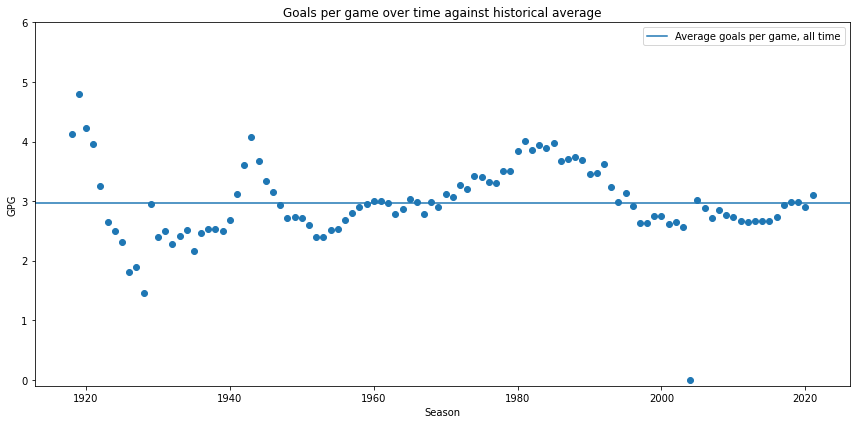

In [33]:
# Collect, e.g., the goals per game over time and plot against average
gpg = [np.mean(stats_dfs[key]['goalsPerGame']) for key in stats_dfs]
plt.figure(figsize=(12, 6))
plt.scatter(all_years, gpg)
plt.ylim(-0.1, 6)
plt.title('Goals per game over time against historical average')
plt.xlabel('Season')
plt.ylabel('GPG')
plt.axhline(np.mean(gpg), label='Average goals per game, all time')
plt.tight_layout()
plt.legend()

In [40]:
np.mean(stats_dfs['19931994']['goalsPerGame'])

3.2422307692307695

In [41]:
# Scaling the data to explore statistical trends
from sklearn import preprocessing

scaler_mm = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler_mm.fit(test_df_mns)

NameError: name 'test_df_mns' is not defined

In [42]:
# Creating a mean-subtracted, normalized dataframe
for column in test_df.columns:
    if type(test_df[column][0]) is str:
        test_df[column] = test_df[column].astype(float)
        
test_df_mns = test_df - test_df.mean()
test_df_scaled = scaler_mm.transform(test_df_mns)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [43]:
# Scatter-plotting all team's statistics to set the winner's against
plt.figure(figsize=(14, 8))

for ind, arr in enumerate(test_df_scaled):
    if ind == test_df.index.get_loc('COL'):
        plt.plot(np.arange(len(stat_cols)), arr, linestyle='--', label='Colorado Avalanche, 2000-2001 SC winners')
        plt.scatter(np.arange(len(stat_cols)), arr, marker='.')
    else:
        plt.scatter(np.arange(len(stat_cols)), arr, marker='.')
    
plt.title('Stanley Cup winner statistical path')
plt.xticks(np.arange(len(stat_cols[:-1])), stat_cols[:-1], rotation=90)
plt.rc('xtick', labelsize=12)
plt.ylabel('Normalized, mean-subtracted statistical value')
plt.legend(loc=0, fontsize='large')

NameError: name 'test_df_scaled' is not defined

<Figure size 1008x576 with 0 Axes>